# Twitter Classification

The first goal of this project is to predict whether a tweet will go viral using a K-Nearest Neighbour classifier. The second is to determine whether a tweet was sent from New York, London, or Paris using Logistic Regression and Naive Bayes classifiers with vectorization of different sparsity levels applied to their features. Therefore, in the first part we'll try to understand what influences tweet's virality most: tweet's length, number of links/hashtags, language or account info. In the second part we will investigate how language influences the classification choice and how much we can additionally contribute to this choice using different vectorisation technics.

Dataset is provided by codecademy. Data was collected somewhere

## Classifying Tweets by Virality

### Investigation and Cleaning

Let's start by importing necessary tools, loading first part of the data `random_tweets` in `all_tweets` variable and displaying some basic info about this dataset.

Note: random_tweets.json is a large file, so won't be uploaded to GitHub.

In [78]:
# Basic imports related to analysis
import pandas as pd
import numpy as np

# Imports for files processing
import os
import pickle

# Imports related to visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Imports related to preprocessing
from sklearn.preprocessing import scale
import sklearn.utils


# Imports related to ml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


Note: we are going to use pickle to speed up running time, so in some cells will be placed pickle functions.

In [2]:
def pickle_object(object, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(object, f)

def unpickle_object(file_path):
    if not os.path.isfile(file_path):
        return None
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def with_pickle(file_path, fun):
    value = unpickle_object(file_path)
    if value is None:
        value = fun()
        pickle_object(value, file_path)
    return value

In [3]:
# Display all columns
pd.set_option('display.max_columns', None)

# Read json file
all_tweets = pd.read_json("random_tweets.json", lines=True)
all_tweets.head(3)

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,withheld_in_countries
0,2018-07-31 13:34:40+00:00,1024287229525598210,1024287229525598208,RT @KWWLStormTrack7: We are more than a month ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 145388018, 'id_str': '145388018', 'name...",None,None,None,NaN,{'created_at': 'Mon Jul 30 16:49:41 +0000 2018...,False,3,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-31 13:34:40+00:00,1024287229512953856,1024287229512953856,@hail_ee23 Thanks love its just the feeling of...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.024128e+18,1.024128e+18,9.271857e+17,9.271857e+17,hail_ee23,"{'id': 2407992339, 'id_str': '2407992339', 'na...",None,None,"{'id': '26b41b13d49ea2bf', 'url': 'https://api...",NaN,NaN,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-31 13:34:40+00:00,1024287229504569344,1024287229504569344,RT @TransMediaWatch: Pink News has more on the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 901579698223931392, 'id_str': '90157969...",None,None,None,NaN,{'created_at': 'Tue Jul 31 11:03:32 +0000 2018...,False,5,0,False,False,en,0.0,NaN,NaN,NaN,NaN,NaN


In [80]:
def visualise_heatmap(dataset_corr, corr_objects, cmap):
    # Prepare figure
    plt.figure(figsize = (21,12))

    # Draw heatmap as triangle
    mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
    # Add descriptions
    plt.title(' Correlations of ' + corr_objects, fontsize= 'x-large')
    plt.xticks(rotation=45)

    # Plot heatmap
    heatmap = sns.heatmap(dataset_corr, annot=True, vmax=1, vmin=-1, cmap=cmap, mask=mask)
    return heatmap

That's a lot of columns. Let's check the dataset's metadata to find more. 

In [4]:
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11099 entries, 0 to 11098
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 11099 non-null  datetime64[ns, UTC]
 1   id                         11099 non-null  int64              
 2   id_str                     11099 non-null  int64              
 3   text                       11099 non-null  object             
 4   truncated                  11099 non-null  bool               
 5   entities                   11099 non-null  object             
 6   metadata                   11099 non-null  object             
 7   source                     11099 non-null  object             
 8   in_reply_to_status_id      1402 non-null   float64            
 9   in_reply_to_status_id_str  1402 non-null   float64            
 10  in_reply_to_user_id        1503 non-null   float64            
 11  in

Apparently, some columns are dictionaries, for example, column `user`. So we might use some information found within them. 

In [5]:
all_tweets.loc[0]["user"]

{'id': 145388018,
 'id_str': '145388018',
 'name': 'Derek Wolkenhauer',
 'screen_name': 'derekw221',
 'location': 'Waterloo, Iowa',
 'description': '',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 215,
 'friends_count': 335,
 'listed_count': 2,
 'created_at': 'Tue May 18 21:30:10 +0000 2010',
 'favourites_count': 3419,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': False,
 'statuses_count': 4475,
 'lang': 'en',
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '022330',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme15/bg.png',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme15/bg.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/995790590276243456/cgxRVviN_normal.jpg',
 'profile_image_url_https': 'https://pbs.twimg.com/profile

For example, we could fish out user's nick and location out of the `user` dictionary.

In [6]:
all_tweets.loc[0]['user']['screen_name']

'derekw221'

In [7]:
all_tweets.loc[0]['user']['location']

'Waterloo, Iowa'

Result: 
- There are a lot of empty fields in this dataset, some them marked as `NaN` and others as `None`, nevertheless both considered as missing values. 
- Some columns were auto-converted by `pandas` from strings to integers, though were meant to be kept as strings in `json`, as `id_str` for instance.  

Considering our current goals, we won't need most of the data from this dataset, so there is no need to correct small flaws, mentioned above at the moment, we can just proceed as it is. 

### Defining Viral Tweets

A K-Nearest Neighbor classifier is a supervised machine learning algorithm, so we need to have a dataset with tagged labels to work with it. So to predict virality we first need to mark each tweet in this dataset as `viral` or `not viral`.

We will start by looking at statistics of retweets.

In [8]:
all_tweets.retweet_count.describe()

count     11099.000000
mean       2777.956392
std       12180.169923
min           0.000000
25%           0.000000
50%          13.000000
75%         428.500000
max      413719.000000
Name: retweet_count, dtype: float64

`50%` of tweets have 13 retweets, looks like a good number to determine whether tweet is viral or not.

In [9]:
all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > all_tweets.retweet_count.median(), 1, 0)
all_tweets.is_viral.head()

0    0
1    0
2    0
3    1
4    0
Name: is_viral, dtype: int32

### Making Features

Now that we've created a label for every tweet in our dataset, we can begin thinking about which features might determine whether a tweet is viral. We can create new columns in our dataset to represent these features. 

Our fearues will be (some are self-explanatory): 
- `tweet_length`; 
- `followers_count` - Number of followers of an account a tweet was posted by; 
- `friends_count` - Number of friends of an account; 
- `tweet_hashtags` - Number of `#` signs in a tweet;
- `tweet_links`; 
- `tweet_words_count`;
- `words_avg_lenth` - average length of tweet's words.

Note: Unfortunately the datasets I use in this project don't have `likes` column in them,  instead they have `favourite` column which was replaced by likes somewhere in 2015.

In [10]:
# Add new column to all_tweets dataset
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
all_tweets.tweet_length.head()

0    140
1     77
2    140
3    140
4    140
Name: tweet_length, dtype: int64

In [11]:
# Add new column to all_tweets dataset
all_tweets['followers_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
all_tweets.followers_count.head()

0     215
1     199
2     196
3    3313
4     125
Name: followers_count, dtype: int64

In [12]:
# Add new column to all_tweets dataset
all_tweets['friends_count'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis=1)
all_tweets.friends_count.head()

0     335
1     203
2     558
3    2272
4     273
Name: friends_count, dtype: int64

In [13]:
# Add new column to all_tweets dataset
all_tweets['tweet_hashtags'] = all_tweets.apply(lambda tweet: tweet['text'].count('#'), axis=1)

How many tweets have more than 5 hashtags? 

In [14]:
len(all_tweets.tweet_hashtags[all_tweets.tweet_hashtags > 5])

35

In [15]:
# Add new column to all_tweets dataset
all_tweets['tweet_links'] = all_tweets['text'].str.count(r'http(s)?')

How many tweets with more than one link we got?

In [16]:
len(all_tweets[all_tweets.tweet_links > 1])

176

In [17]:
# Add new column to all_tweets dataset
all_tweets['tweet_words_count'] = all_tweets.apply(lambda tweet: len(tweet['text'].split()), axis=1)


How many words people use in tweets on average and in most cases? 

In [18]:
all_tweets.tweet_words_count.describe()

count    11099.000000
mean        19.461753
std          5.680495
min          1.000000
25%         16.000000
50%         21.000000
75%         24.000000
max         41.000000
Name: tweet_words_count, dtype: float64

In [19]:
# Add new column to all_tweets dataset
all_tweets['words_avg_lenth'] = all_tweets.apply(lambda tweet: np.mean([len(word) for word in tweet['text'].split()]), axis=1)
all_tweets.words_avg_lenth.head()


0    4.423077
1    4.200000
2    5.409091
3    4.875000
4    4.875000
Name: words_avg_lenth, dtype: float64

Before we go any further let's take a glimpse to correlation matrix and understand what correlations our features have with tweet's virality.

In [90]:
metrics = all_tweets[[
    'text',
    'is_viral',
    'tweet_length', 
    'followers_count', 
    'friends_count', 
    'tweet_links', 
    'tweet_hashtags', 
    'tweet_words_count', 
    'words_avg_lenth'
    ]]
metrics.corr()

,is_viral,tweet_length,followers_count,friends_count,tweet_links,tweet_hashtags,tweet_words_count,words_avg_lenth
is_viral,1.000000,0.222237,-0.019830,-0.016200,-0.252995,0.015000,0.260649,-0.102148
tweet_length,0.222237,1.000000,0.007666,0.030084,-0.064049,0.093148,0.815694,-0.119345
followers_count,-0.019830,0.007666,1.000000,0.059670,0.015929,-0.004509,0.007181,-0.003556
friends_count,-0.016200,0.030084,0.059670,1.000000,0.001047,0.014447,0.011182,0.007115
tweet_links,-0.252995,-0.064049,0.015929,0.001047,1.000000,0.075466,-0.334687,0.341057
tweet_hashtags,0.015000,0.093148,-0.004509,0.014447,0.075466,1.000000,-0.050531,0.122161
tweet_words_count,0.260649,0.815694,0.007181,0.011182,-0.334687,-0.050531,1.000000,-0.539950
words_avg_lenth,-0.102148,-0.119345,-0.003556,0.007115,0.341057,0.122161,-0.539950,1.000000


Result: there is a small positive correlation of virality with `tweet_length` (0.22), `tweet_words_count`(0.26), small negative with  `tweet_links`(-0.25) and even smaller negative with `words_avg_lenth`(-0.1). That's not great, but not too bad either.

Let's proceed with the project by creating separate variables `features` in which we'll put all our new columns and `classes`, where `is_viral` column will go to.

In [20]:
features = all_tweets[
    ['tweet_length', 
    'followers_count', 
    'friends_count', 
    'tweet_links', 
    'tweet_hashtags', 
    'tweet_words_count', 
    'words_avg_lenth']
    ]
classes = all_tweets.is_viral

### Normalizing The Data

Let's now normalise our features so their scales wouldn't be so drastically different and model would give them adequate rate of importance. We are going to use Z-score normalization from `scikit-learn`.

In [21]:
features_scaled = scale(features)

# Display first row
features_scaled[0]

array([ 0.6164054 , -0.02878298, -0.14483305, -0.78415588, -0.32045057,
        1.15105133, -0.63295806])

### Creating Training and Testing Sets

To evaluate the effectiveness of our classifier, we now split `features_scaled` and `classes` into a training sets and testing sets using scikit-learn's `train_test_split` function.

In [22]:
# Split data into training and testing sets
train_features, test_features, train_classes, test_classes = train_test_split(
    features_scaled, 
    classes, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=3
    )

# Display first 5 rows
train_classes[:5]

8237    1
198     1
7877    0
5771    0
7258    1
Name: is_viral, dtype: int32

In [23]:
# Display first 5 rows
train_features[:5]

array([[ 0.6164054 , -0.02737219, -0.1083415 , -0.78415588, -0.32045057,
         0.62290454, -0.26795305],
       [ 0.6164054 , -0.02977649, -0.16118231, -0.78415588, -0.32045057,
         0.44685561, -0.21798353],
       [ 0.58049776, -0.02694497, -0.12900696,  1.11738358, -0.32045057,
        -0.08129118,  0.37086248],
       [ 0.6164054 , -0.02532058,  0.06888449,  1.11738358, -0.32045057,
        -1.66573155,  3.84443672],
       [-0.85580803, -0.02402901, -0.0683185 ,  1.11738358, -0.32045057,
        -0.7854869 ,  0.00874893]])

### Find best K value

Our next task is to find the `k` nearest classified neighbours of the unclassified point using K-Nearest Neighbour Algorithm. 

The idea behind it is finding `k` number of known data-points that are most related from features perspective to the unknown data-point using distance formula, after what just put the unknown data-point in the same class as the majority of known most related to it data-points already are. 

But before creating the best possible classifier we should find the best value for the parameter `n_neighbors` or `k`. To find it we'll try to run the classifier with a bunch of different values from 1 to 200 and choose the one with the highest accuracy level. 


In [24]:
# Get accuracy scores for 200 different k values
def get_scores():
    scores=[]
    for k in range(1, 200):
        # Instantiate model
        classifier = KNeighborsClassifier(n_neighbors=k)
        # Train the model
        classifier.fit(train_features, train_classes)
        # Get model's accuracy
        scores.append(classifier.score(test_features, test_classes))

    # Get first 5 accuracy values
    return scores

scores = with_pickle('pickles/get_scores.pickle', lambda: get_scores()) 

Let's get those values on a graph to see how the accuracy changes depending on the `k`- value changes.

Text(0, 0.5, 'Accuracy')

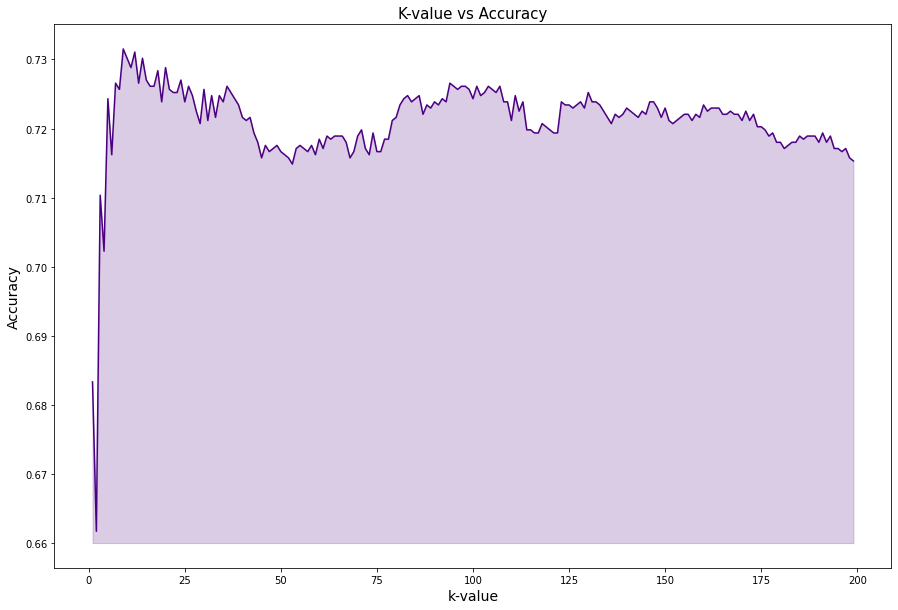

In [25]:
plt.figure(figsize=(15,10))
plt.plot(range(1, 200), scores, color='Indigo')
plt.fill_between(range(1, 200), 0.66, scores,
                 facecolor="Indigo", # The fill color
                 color='Indigo',     # The outline color
                 alpha=0.2) 

plt.title('K-value vs Accuracy', fontsize=15)
plt.xlabel('k-value', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

Now we can find our best value of k by the highest accuracy value.

In [26]:
# Get maximum value of accuracy
np.max(scores)

0.7315315315315315

In [27]:
# Find k value that gets maximum accuracy
scores.index(np.max(scores)) + 1

9

In [28]:
# Instantiate model with best k
best_k_classifier = KNeighborsClassifier(n_neighbors=scores.index(np.max(scores)) + 1)
# Train the model
best_k_classifier.fit(train_features, train_classes)
# Get model's accuracy
print('Accuracy: ', best_k_classifier.score(test_features, test_classes).round(2) *100, '%')

Accuracy:  73.0 %


### Emulation of Extrinsic evaluation

Now we are going to get 10 viral tweets to this date 04.08.22 and 10 non viral tweets from english speaking twitter accounts and will test our classifier on them.

In [29]:
# Read json file
fresh_tweets = pd.read_json("fresh_test_tweets.json", lines=True)
pd.set_option('display.max_colwidth', None)
fresh_tweets

,text,friends_count,followers_count,is_viral
0,A Wren's real voice.,80,1415393,1
1,"Welcome to the Paldea region, Trainers! 🤩 A sprawling land of vast open spaces— dotted with lakes, towering peaks, wastelands, and perilous mountain ranges. See you there! 🧳❤️💜 #PokemonScarletViolet",50,7240285,1
2,"After 11 years with #lcfc, Kasper Schmeichel has joined Nice, ending his incredible spell with the Foxes 💙",126,2566960,1
3,Joker 2' takes place largely in Arkham Asylum,123,626594,1
4,BUTTER DOG #PokemonScarletViolet,657,15899,1
5,"It's great to work at the interface of hardware, software, and biology, because you can get frustrated by three entirely different kinds of toolchains",582,570,1
6,"The BioSynSys symposium on Synthetic and Systems Biology is now open for registrations/ submissions. Date: 12-14 September 2022. Location: The Learning Planet Institute, Paris. Register at: https://biosynsys2022.sciencesconf.org",535,468,1
7,"If you're interested in a DPhil @OxfordBiology studying ecology/evolution/genomics of host-parasite interactions, get in touch. Friendly lab and timely questions! #globalclimatechange #infectiousdisease",1051,2549,1
8,Here's how it sounds when rival gangs of giant otters spot each other.,111,1661,1
9,After almost 2 decades of #research & #exploration with some fantastic collaborations along the way we were able to compile this booklet on #skyisland #reptiles of #WesternGhats. With support from @InsideNatGeo we publish 500 printed copies & free #ebook. A 🧵:,1120,1448,1


As we can see not all tweets that have gone viral have thousands of followers. But if one would browse through `Explore` page of Twitter, like I did, one could find out that most accounts which produce viral tweets have a lot of followers. Although not all posts of such accounts are retweeted heavily, sometimes they have just many likes on them. Anyway, let's add missing coulmns to create full list of features. 

In [30]:
def add_columns(dataframe):
    dataframe['tweet_length'] = dataframe.apply(lambda tweet: len(tweet['text']), axis=1)
    dataframe['tweet_hashtags'] = dataframe.apply(lambda tweet: tweet['text'].count('#'), axis=1)
    dataframe['tweet_links'] = dataframe['text'].str.count(r'http(s)?')
    dataframe['tweet_words_count'] = dataframe.apply(lambda tweet: len(tweet['text'].split()), axis=1)
    dataframe['words_avg_lenth'] = dataframe.apply(lambda tweet: np.mean([len(word) for word in tweet['text'].split()]), axis=1)
    return dataframe


fresh_tweets = add_columns(fresh_tweets)
fresh_tweets[:3]

,text,friends_count,followers_count,is_viral,tweet_length,tweet_hashtags,tweet_links,tweet_words_count,words_avg_lenth
0,A Wren's real voice.,80,1415393,1,20,0,0,4,4.250000
1,"Welcome to the Paldea region, Trainers! 🤩 A sprawling land of vast open spaces— dotted with lakes, towering peaks, wastelands, and perilous mountain ranges. See you there! 🧳❤️💜 #PokemonScarletViolet",50,7240285,1,198,1,0,29,5.862069
2,"After 11 years with #lcfc, Kasper Schmeichel has joined Nice, ending his incredible spell with the Foxes 💙",126,2566960,1,106,1,0,18,4.944444


In [31]:
features_fresh_shuffled = sklearn.utils.shuffle(fresh_tweets).reset_index(drop=True)
features_fresh_shuffled[:3]

,text,friends_count,followers_count,is_viral,tweet_length,tweet_hashtags,tweet_links,tweet_words_count,words_avg_lenth
0,BUTTER DOG #PokemonScarletViolet,657,15899,1,32,1,0,3,10.000000
1,"Hey, @VinnyCaravella and I spent some time in Elden Ring trying to run a horse up a cliff and make a guy swim in full plate armor.",590,88982,0,130,0,0,27,3.851852
2,"BREAKING: Agency Strategic Planner Comes Up With Unique Insight That Today's Families Lead 'Busy, Hectic Lifestyles' According To Stock Photo In Deck",0,92442,0,149,0,0,22,5.818182


Now we can calculate missing features.

In [32]:
features_fresh = fresh_tweets[
    ['tweet_length', 
    'followers_count', 
    'friends_count', 
    'tweet_links', 
    'tweet_hashtags', 
    'tweet_words_count', 
    'words_avg_lenth']
    ]
features_fresh[:5]

,tweet_length,followers_count,friends_count,tweet_links,tweet_hashtags,tweet_words_count,words_avg_lenth
0,20,1415393,80,0,0,4,4.250000
1,198,7240285,50,0,1,29,5.862069
2,106,2566960,126,0,1,18,4.944444
3,45,626594,123,0,0,8,4.750000
4,32,15899,657,0,1,3,10.000000


In [33]:
features_fresh_scaled = scale(features_fresh)
features_fresh_scaled[:3]

array([[-1.64290742,  0.48872682, -0.67399778, -0.5       , -0.44232587,
        -1.54795547, -0.96346468],
       [ 1.11593712,  4.03624296, -0.6974371 , -0.5       ,  0.29488391,
         1.03197031, -0.06426285],
       [-0.30998253,  1.19006214, -0.63805748, -0.5       ,  0.29488391,
        -0.10319703, -0.57610798]])

In [34]:
fresh_predicts = best_k_classifier.predict(features_fresh_scaled).tolist()
fresh_predicts

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]

In [68]:
features_fresh_shuffled['predicted_virality'] = fresh_predicts
features_fresh_shuffled = features_fresh_shuffled[[
    'text',
    'is_viral',
    'predicted_virality',
    'tweet_length', 
    'followers_count', 
    'friends_count', 
    'tweet_links', 
    'tweet_hashtags', 
    'tweet_words_count', 
    'words_avg_lenth']]
features_fresh_shuffled[:3]

,text,is_viral,predicted_virality,tweet_length,followers_count,friends_count,tweet_links,tweet_hashtags,tweet_words_count,words_avg_lenth
0,BUTTER DOG #PokemonScarletViolet,1,0,32,15899,657,0,1,3,10.000000
1,"Hey, @VinnyCaravella and I spent some time in Elden Ring trying to run a horse up a cliff and make a guy swim in full plate armor.",0,0,130,88982,590,0,0,27,3.851852
2,"BREAKING: Agency Strategic Planner Comes Up With Unique Insight That Today's Families Lead 'Busy, Hectic Lifestyles' According To Stock Photo In Deck",0,0,149,92442,0,0,0,22,5.818182


In [75]:
pd.DataFrame(confusion_matrix(fresh_predicts, features_fresh_shuffled.is_viral), columns = ['negatives', 'positives']) 


,negatives,positives
0,7,8
1,3,2


This output tells us that there are:
- `7` true negatives, `3` false negative, 
- `2` true positives, and `8` false positives. 

That is a pretty bad result. Ideally, we want the numbers on the main diagonal (in this case, 7 and 2, which are the true negatives and true positives, respectively) to be as large as possible.



## Classifying Tweets by Location

We've been given three files: `new_york.json`, `london.json`, and `paris.json`. These three files contain tweets that we gathered from those locations. The goal is to create a classification algorithm that can classify any tweet (or sentence) and predict whether that sentence came from New York, London, or Paris. 

We are going to use text augmentation by BERT to generate more data and even it out between classes if required. 
To get better possible classification for current dataset we are going to compare 2 variants:
 - Sparse matrix from Count Vectoriser with Multinomial Naive Bayes classifier.
 - Dense matrix from word2vec with Logistic Regression classifier.

Let's start by performing necessary imports.

In [37]:
# Imports related to preprocessing
from nltk import word_tokenize
from nltk.corpus import stopwords
import re

# Imports related to ml
import nlpaug.augmenter.word as naw
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


# Imports related to evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Investigate Data

In [38]:
ny_tweets = pd.read_json("new_york.json", lines=True)
ny_tweets.head(1)

,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms,extended_tweet,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities,withheld_in_countries
0,2018-07-26 13:32:33+00:00,1022474755625164800,1022474755625164800,@DelgadoforNY19 Calendar marked.,"[16, 32]","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,1.022208e+18,1.022208e+18,8.290618e+17,8.290618e+17,DelgadoforNY19,"{'id': 316616881, 'id_str': '316616881', 'name': 'Adam Ford', 'screen_name': 'NYCVermouth', 'location': 'New York City', 'url': 'http://www.fordobrien.com', 'description': 'White Collar Criminal Defense Lawyer. Atsby Vermouth founder. Authored the Vermouth book. I keep threatening to start a podcast.', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 612, 'friends_count': 615, 'listed_count': 17, 'favourites_count': 3813, 'statuses_count': 2109, 'created_at': 'Mon Jun 13 18:23:44 +0000 2011', 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'lang': 'en', 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_link_color': '1DA1F2', 'profile_sidebar_border_color': 'C0DEED', 'profile_sidebar_fill_color': 'DDEEF6', 'profile_text_color': '333333', 'profile_use_background_image': True, 'profile_image_url': 'http://pbs.twimg.com/profile_images/666809966087569408/2SXv_gFM_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/666809966087569408/2SXv_gFM_normal.jpg', 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/316616881/1447815868', 'default_profile': True, 'default_profile_image': False, 'following': None, 'follow_request_sent': None, 'notifications': None}",None,None,"{'id': '01a9a39529b27f36', 'url': 'https://api.twitter.com/1.1/geo/id/01a9a39529b27f36.json', 'place_type': 'city', 'name': 'Manhattan', 'full_name': 'Manhattan, NY', 'country_code': 'US', 'country': 'United States', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[-74.026675, 40.683935], [-74.026675, 40.877483], [-73.910408, 40.877483], [-73.910408, 40.683935]]]}, 'attributes': {}}",NaN,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': [{'screen_name': 'DelgadoforNY19', 'name': 'Antonio Delgado', 'id': 829061809135030272, 'id_str': '829061809135030272', 'indices': [0, 15]}], 'symbols': []}",False,False,low,en,2018-07-26 13:32:33.060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
ny_tweets.lang.unique()

array(['en', 'es', 'und', 'ja', 'ht', 'in', 'tl', 'fr', 'ur', 'ar', 'it',
       'tr', 'no', 'ca', 'de', 'hu', 'sv', 'nl', 'pt', 'pl', 'cy', 'lv',
       'et', 'ru', 'ro', 'zh', 'ko', 'lt', 'hi', 'da', 'am', 'th', 'cs'],
      dtype=object)

In [40]:
p_tweets = pd.read_json("paris.json", lines=True)
p_tweets.head(1)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_entities,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet
0,2018-07-27 17:40:45+00:00,1022899608396156928,1022899608396156928,Bulletin météo parisien : des grêlons énormes s'abattent sur nous. La température à dégringoler de 36 A20 😍😍😍😍😍,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,NaN,NaN,NaN,None,"{'id': 898983688960167936, 'id_str': '898983688960167936', 'name': 'l'idiopathe', 'screen_name': 'olivier7399', 'location': 'Paris, France', 'url': None, 'description': '#bibliothécaire et #francophone', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 18, 'friends_count': 21, 'listed_count': 1, 'favourites_count': 1906, 'statuses_count': 236, 'created_at': 'Sat Aug 19 19:03:08 +0000 2017', 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'lang': 'fr', 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': '', 'profile_background_image_url_https': '', 'profile_background_tile': False, 'profile_link_color': '1DA1F2', 'profile_sidebar_border_color': 'C0DEED', 'profile_sidebar_fill_color': 'DDEEF6', 'profile_text_color': '333333', 'profile_use_background_image': True, 'profile_image_url': 'http://pbs.twimg.com/profile_images/898989015017414656/vYg0YFEE_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/898989015017414656/vYg0YFEE_normal.jpg', 'default_profile': True, 'default_profile_image': False, 'following': None, 'follow_request_sent': None, 'notifications': None}",None,None,"{'id': '09f6a7707f18e0b1', 'url': 'https://api.twitter.com/1.1/geo/id/09f6a7707f18e0b1.json', 'place_type': 'city', 'name': 'Paris', 'full_name': 'Paris, France', 'country_code': 'FR', 'country': 'France', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[2.224101, 48.815521], [2.224101, 48.902146], [2.469905, 48.902146], [2.469905, 48.815521]]]}, 'attributes': {}}",NaN,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': [], 'symbols': []}",False,False,low,fr,2018-07-27 17:40:45.854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
p_tweets.lang.unique()

array(['fr', 'in', 'ar', 'en', 'pt', 'ru', 'und', 'es', 'nl', 'ro', 'it',
       'tl', 'zh', 'tr', 'ja', 'de', 'uk', 'ca', 'ur', 'ht', 'et', 'pl',
       'ko', 'fi', 'hi', 'sv', 'fa', 'vi', 'is'], dtype=object)

In [42]:
l_tweets = pd.read_json("london.json", lines=True)
l_tweets.head(1)

,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,extended_tweet,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities
0,2018-07-26 13:39:30+00:00,1022476504855400449,1022476504855400448,@bbclaurak i agree Laura but the Party you seem to support so strongly is slowly doing the same thing . . . and usi… https://t.co/tsRsVBozIR,"[11, 140]","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",True,1.022447e+18,1.022447e+18,61183568.0,61183568.0,bbclaurak,"{'id': 340170806, 'id_str': '340170806', 'name': 'Big Bobs bastard beans', 'screen_name': 'annoyed_aldo', 'location': None, 'url': None, 'description': 'Memento Mori . . . check my timeline before following me 😒😒 come at me bitches . . . I’ll just block your racist, hateful asses . . .', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 775, 'friends_count': 1523, 'listed_count': 60, 'favourites_count': 16805, 'statuses_count': 38211, 'created_at': 'Fri Jul 22 07:43:07 +0000 2011', 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'lang': 'en', 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_link_color': '1DA1F2', 'profile_sidebar_border_color': 'C0DEED', 'profile_sidebar_fill_color': 'DDEEF6', 'profile_text_color': '333333', 'profile_use_background_image': True, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1022042988418134016/jgnVpHD2_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1022042988418134016/jgnVpHD2_normal.jpg', 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/340170806/1483202068', 'default_profile': True, 'default_profile_image': False, 'following': None, 'follow_request_sent': None, 'notifications': None}",None,None,"{'id': '58f909abfd95e133', 'url': 'https://api.twitter.com/1.1/geo/id/58f909abfd95e133.json', 'place_type': 'city', 'name': 'Lewisham', 'full_name': 'Lewisham, London', 'country_code': 'GB', 'country': 'United Kingdom', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[-0.074547, 51.414087], [-0.074547, 51.494127], [0.038567, 51.494127], [0.038567, 51.414087]]]}, 'attributes': {}}",NaN,False,"{'full_text': '@bbclaurak i agree Laura but the Party you seem to support so strongly is slowly doing the same thing . . . and using you as their puppet 😐😐😐', 'display_text_range': [11, 141], 'entities': {'hashtags': [], 'urls': [], 'user_mentions': [{'screen_name': 'bbclaurak', 'name': 'Laura Kuenssberg', 'id': 61183568, 'id_str': '61183568', 'indices': [0, 10]}], 'symbols': []}}",0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.co/tsRsVBozIR', 'expanded_url': 'https://twitter.com/i/web/status/1022476504855400449', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}], 'user_mentions': [{'screen_name': 'bbclaurak', 'name': 'Laura Kuenssberg', 'id': 61183568, 'id_str': '61183568', 'indices': [0, 10]}], 'symbols': []}",False,False,low,en,2018-07-26 13:39:30.109,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
l_tweets.lang.unique()

array(['en', 'und', 'ru', 'ar', 'et', 'pt', 'es', 'it', 'ta', 'tl', 'tr',
       'fr', 'ja', 'pl', 'fa', 'in', 'zh', 'ur', 'iw', 'da', 'ko', 'te',
       'cy', 'hi', 'ht', 'de', 'sv', 'ro', 'nl', 'hu', 'eu', 'ca', 'fi',
       'dv', 'cs', 'uk', 'th'], dtype=object)

Result: Paris' tweets are mostly in French, but there are some English, Arabic, Spanish  and other languages in each dataset, so we'll add all these languages to stop words set below, but it's clear that the main distinctive characteristic for Paris's dataset will be dominance of French in tweets.

In [44]:
ny_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4723 entries, 0 to 4722
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 4723 non-null   datetime64[ns, UTC]
 1   id                         4723 non-null   int64              
 2   id_str                     4723 non-null   int64              
 3   text                       4723 non-null   object             
 4   display_text_range         2811 non-null   object             
 5   source                     4723 non-null   object             
 6   truncated                  4723 non-null   bool               
 7   in_reply_to_status_id      1668 non-null   float64            
 8   in_reply_to_status_id_str  1668 non-null   float64            
 9   in_reply_to_user_id        1829 non-null   float64            
 10  in_reply_to_user_id_str    1829 non-null   float64            
 11  in_r

In [45]:
p_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 2510 non-null   datetime64[ns, UTC]
 1   id                         2510 non-null   int64              
 2   id_str                     2510 non-null   int64              
 3   text                       2510 non-null   object             
 4   source                     2510 non-null   object             
 5   truncated                  2510 non-null   bool               
 6   in_reply_to_status_id      1040 non-null   float64            
 7   in_reply_to_status_id_str  1040 non-null   float64            
 8   in_reply_to_user_id        1101 non-null   float64            
 9   in_reply_to_user_id_str    1101 non-null   float64            
 10  in_reply_to_screen_name    1101 non-null   object             
 11  user

In [46]:
l_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5341 entries, 0 to 5340
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 5341 non-null   datetime64[ns, UTC]
 1   id                         5341 non-null   int64              
 2   id_str                     5341 non-null   int64              
 3   text                       5341 non-null   object             
 4   display_text_range         3535 non-null   object             
 5   source                     5341 non-null   object             
 6   truncated                  5341 non-null   bool               
 7   in_reply_to_status_id      2230 non-null   float64            
 8   in_reply_to_status_id_str  2230 non-null   float64            
 9   in_reply_to_user_id        2444 non-null   float64            
 10  in_reply_to_user_id_str    2444 non-null   float64            
 11  in_r

The same flaws that we had in the previous dataset are present here, but I doubt that they would do any harm right now, so proceeding analysing datasets as they are.

### Text augmentation

To increase our chances of getting good results from intrinsic testing we are going to perform automatic text augmentation using BERT. Our augmenter accepts only list of strings, so we are going to convert our texts to lists and remove links from them to make things easier for further preprocessing steps. 

In [47]:
# Remove links and convert to lists each dataset
def convert_clean(dataset):
    return dataset.text.str.replace(r'''[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)''', 
    '', 
    regex=True
    ).to_list()

p_tw_list = convert_clean(p_tweets)
l_tw_list = convert_clean(l_tweets)
ny_tw_list = convert_clean(ny_tweets)
p_tw_list[:5]

["Bulletin météo parisien : des grêlons énormes s'abattent sur nous. La température à dégringoler de 36 A20 😍😍😍😍😍",
 'Prêt pour le match #USORCL ',
 "MAIS QOIDBDNND'SLS'SLSLLSLS''D DBDODNDNODJDBKDLDLDLLDMDMDMEMD' DNDBISKENvzjks\nKENTARO MIURA N'EST PAS UN HUMAIN ",
 '@ToursFC Où peut on le championnat de National...?',
 'Les tismey ils sont bas qu’a tromper leur go et faire les putes']

In [48]:
def text_augment(text):
    # Augment texts using BERT
    aug = naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', aug_p=0.1)
    return aug.augment(text)

We are going to augment the whole list of tweets from Paris and those from NY but partially. The goal is to get about 5000 tweets for each city as a result.

In [49]:
# Augment Paris' tweets
p_aug = with_pickle('pickles/p_aug.pickle', lambda : text_augment(p_tw_list))
# Augment NY's tweets
ny_aug = with_pickle('pickles/ny_aug.pickle', lambda : text_augment(ny_tw_list[:1000]))

# Attach augmented tweets from Paris to initial list
p_tweets_aug = p_tw_list + p_aug
# Get new number of Paris tweets
len(p_tweets_aug)

5020

In [50]:
# Attach augmented tweets from NY to initial list
ny_tweets_aug = ny_tw_list + ny_aug
len(ny_tweets_aug)

5723

In [51]:
# Collect all tweets in one list
all_tweets_aug = ny_tweets_aug + p_tweets_aug + l_tw_list
# Get total number of tweets
len(all_tweets_aug)

16084

Result: we got ourselves `16 084` tweets for further work.

### Preprocessing

One of our feature modelling technics - word embeddings, using word2vec, requires cleaned and tokenised text, so we'll preprocess our augmented text for it and then devide it for training and testing sets. 

In [52]:
# Make stop words set from several languages
all_stopwords = set()
languages = ['english', 'french', 'arabic', 'spanish', 'indonesian', 'portuguese', 'russian']
for language in languages:
    all_stopwords |= set(stopwords.words(language))

In [53]:
# Preprocess the text.
def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        # Nested function that lowercases, removes stopwords, digits if they are not from a list of tokens
        return [token.lower() for token in tokens if token not in all_stopwords
            and not token.isdigit()
            and re.match(r'\W+', token) is None] 
    return [remove_stops_digits(word_tokenize(text)) for text in texts]


In [54]:
text_processed = preprocess_corpus(all_tweets_aug)
text_processed[:3]

[['delgadoforny19', 'calendar', 'marked'],
 ['petition', 'ban', 'one', 'spritz', 'cologne'],
 ['people', 'really', 'making', 'beef', 'head', 'lol']]

### Creating Training and Testing Sets for 1st Classifier

Considering, we using supervised algos, we need a list of labels to teach our models, so let's make it from augmented texts. Labels will be associated with the tweets: 
- `0` New York tweet;
- `1` London tweet, 
- `2` Paris tweet. 

In [55]:
labels = [0] * len(ny_tweets_aug) + [1] * len(p_tweets_aug) + [2] * len(l_tw_list)
# Get 5 first and 5 last labels
labels[:5], labels[-5:]

([0, 0, 0, 0, 0], [2, 2, 2, 2, 2])

With labels created, we can proceed to splitting data and labels to training and testing sets.

In [56]:
# Split data and labels for train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    text_processed, 
    labels, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=3
    )

train_data[:3]

[['aziz_ajax', 'نقراها'],
 ['whitecarz',
  'tomfawcett88',
  'queen_of_gif',
  'gnasherjew',
  'mrjamesob',
  'labouragainstas',
  'uklabour',
  'catch',
  'phrase',
  'almost',
  't…'],
 ['right', 'robtiffany', 'enjoy', 'rest']]

### Create Word Embeddings

Now we are going to use our train data to create embeddings. 

In [57]:
def train_word2vec(train_data, vector_size, window, min_count, workers, sg, epochs):
    # Instantiate embedding model
    w2v_model = gensim.models.Word2Vec(
        train_data,
        vector_size=vector_size, 
        window=window, 
        min_count=min_count, 
        workers=workers,
        sg=sg, 
        epochs=epochs)
    return w2v_model

# Train embedding model
w2v_model = with_pickle('pickles/w2v_model.pickle', lambda : train_word2vec(
    train_data=train_data, 
    vector_size=1000, 
    window=5, 
    min_count=1, 
    workers=2, 
    sg=1, 
    epochs=1500))

In [58]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_features(list_of_lists):
    DIMENSION = 1000
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model.wv:
                feat_for_this += w2v_model.wv[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats


train_vectors = embedding_features(train_data)
train_vectors[0][:5]

array([ 0.08027908, -0.03416432,  0.07948664,  0.01527151, -0.25814508])

### Create Logistic Regression Classifier

It's time to give the embeddings to the classifier to train it.

In [59]:
# Instantiate classifier
classifier_lr = LogisticRegression(max_iter=1200)
# Train classifier
classifier_lr.fit(train_vectors, train_labels)

LogisticRegression(max_iter=1200)

Now we have first out of 2 classifiers trained. To evaluate the test results of its classification we are going to use automatically building text report showing the main classification metrics for each class:

    - Precision;
    - Recall;
    - F1 score;

When we'll get the second classifier ready we'll also use `confusion matrix` to understand how many predicions were indeed correct. 

In [60]:
# Get predicted labels for test data
preds = classifier_lr.predict(embedding_features(test_data))

# Calculate evaluation metrics
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.56      0.70      0.62      1133
           1       0.88      0.77      0.82      1018
           2       0.63      0.53      0.58      1066

    accuracy                           0.67      3217
   macro avg       0.69      0.67      0.67      3217
weighted avg       0.68      0.67      0.67      3217



Result: First classifier has `67%` of accuracy, which is not great but not too bad either. As one might have guessed it does pretty good on the Paris tweets with `precision`, `recall` and `F1-score` of `88%`, `77%`, `82%` accordingly. But not as good with NY and London tweets with those same metrics in a range from `54%` to `70%`.


### Creating Training and Testing Set for 2nd Classifier

Let's try using sparse matrix and Naive Bayes classifier. This vectoriser uses a raw text, so we'll split the augmented version of it and then will transform it to vectors. 

In [61]:
# Split data and labels for train and test
train_data1, test_data1, train_labels1, test_labels1= train_test_split(
    all_tweets_aug, 
    labels, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=3
    )

train_data[:3]

[['aziz_ajax', 'نقراها'],
 ['whitecarz',
  'tomfawcett88',
  'queen_of_gif',
  'gnasherjew',
  'mrjamesob',
  'labouragainstas',
  'uklabour',
  'catch',
  'phrase',
  'almost',
  't…'],
 ['right', 'robtiffany', 'enjoy', 'rest']]

### Create Naive Bayes Classifier

In [62]:
# Instantiate vectoriser
counter = CountVectorizer()
# Train vectoriser
counter.fit(train_data1)

# Transform train data to vectors
train_counts = counter.transform(train_data1)
# Transform test data to vectors
test_counts = counter.transform(test_data1)

In [63]:
# Instantiate NB classifier
classifier_mlnb = MultinomialNB()
# Train NB classifier
classifier_mlnb.fit(train_counts, train_labels1)

MultinomialNB()

### Evaluate Naive Bayes classifier and Compare Results


In [64]:
# Get accuracy of NB classifier
print('Accuracy:', classifier_mlnb.score(test_counts, test_labels).round(2) * 100, '%')

Accuracy: 74.0 %


Result: Naive Bayes classifier accuracy is better and reaches up to `74%`. But is it the same for all classes or as it's in the case of Linear Regression - superb only for Paris tweets? Let's compare results of 2 classifiers using confusion matrix. 

In [91]:
# Naive Bayes classifier matrix
preds1 = classifier_mlnb.predict(test_counts)

pd.DataFrame(confusion_matrix(preds1, test_labels), columns = ['NY', 'Paris', 'London']) 



,NY,Paris,London
0,960,151,397
1,33,812,49
2,140,55,620


In [92]:
# Logistic Regression classifier matrix
pd.DataFrame(confusion_matrix(preds, test_labels), columns = ['NY', 'Paris', 'London']) 


,NY,Paris,London
0,792,174,446
1,57,787,50
2,284,57,570


Result: Multinomial NB Classifier with sparse matrix has beaten the results of Logistic Regression with dense matrix. Though the main diagonals of both matrixes display the largest numbers, which is good, the numer of false positives in NY tweets which are confused with London's and vice versa is very high: in range from `140` (false positives of London that belong to NY in NB classifier results) to `446` (false positives of NY that belong to London in LR classifier results). Paris is doing much better in both classifications with the ranges of false positives `33 to 49` for NB and `50 to 57` for LR. 


## Conclusion

We have created K-Nearest Neighbour classifier to determine whether a random tweet will go viral or not. Although we have selected features that potentially could influence tweet's virality and intrinsic testing showed `73%` of accuracy. In practice though, there were too much false positives and algorithm predicted less than `50%` of real tweets correctly. One can think of many reasons for that, but the main one would probably be the absence of causal features (those that directly cause increase of virality) and the fact that we've seen a small feature correlations with virality speaks in favour of this hypothesis. This classifier could definitely benefit from adding likes_count column, but even this won't be a causal feature, merely a proxy for it. To understand what causes virality we should have dived deeper into the types of content that cause virality and find patterns there.

We have created 2 classifiers, but used different technics of feature modelling to understand whether we can contribute to classifier's accuracy using more optimized vectorization method. Though we have even up data points within different classes the dominance of French language in Paris tweets remained the most significant criterion and dense matrix produced even lower accuracy than the simple sparse one. Consequentially one might consider using pretrained word embeddings to get better results from applying this technique, but using simple methods as NB classifier and Count Vectorizer might still get decent results without applying many efforts, making it a valuable strategy on its own. 